##### Installing latest version of albumentation because old code doesn't has Coarseout

In [0]:
#!pip install albumentations==0.4.5

In [0]:
%matplotlib inline

### Importing Libraries

In [3]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

drive  sample_data


In [0]:
# Changing working directory
import os
os.chdir('drive/My Drive/EVA4/assignment11')

In [6]:
!ls

 11_final.ipynb      gradcam.py       OCP.py
 assign10	     __init__.py      __pycache__
'Copy of model.py'   lr_finder.py     testalbumentation.py
 data		     model11_old.py   test_.py
 dataset.py	     model11.py       trainalbumentation.py
 general_utils.py    model.py	      train_.py


In [7]:
# checking present working directory
!pwd

/content/drive/My Drive/EVA4/assignment11


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradcam import *

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import math

from dataset import Data
from model import Net

### Downloading train and test dataset using (dataset) module

In [9]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset = data.getTestDataSet(train=False)

Files already downloaded and verified
Files already downloaded and verified


### Creating Test/Train Dataloaders, another train and test loaders to visualise image and gradcam loader which will be used in visualising images using GradCAM

In [0]:
train_loader = data.getDataLoader(dataset=trainset,batches=512)
test_loader = data.getDataLoader(testset,512)
img_train_loader = data.getDataLoader(trainset,5)
img_test_loader = data.getDataLoader(testset,4)
test_grad_loader = data.getDataLoader(testset,1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Visualizing images



  pip install torch-lr-finder -v --global-option="amp"


plane   dog  deer  deer truck


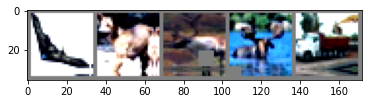

In [11]:
from general_utils import imshow

# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


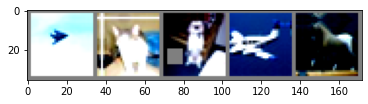

In [12]:
for data, classes in img_train_loader:
  out = torchvision.utils.make_grid(data)
  imshow(out)
  break

### Model Parameters

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

netobj = Net()
model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/content/drive/My Drive/EVA4/assignment11/model11.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


### Finding Best Learning rate through (lr_finder) module

/content/drive/My Drive/EVA4/assignment11/model11.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


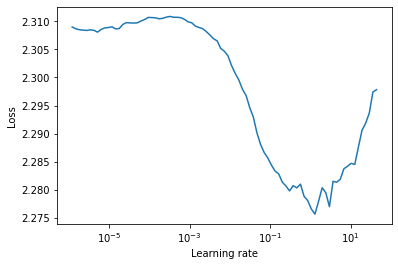

In [0]:
from general_utils import lr_finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder(model, optimizer, criterion, train_loader)
#lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

### Training and Testing Loss

In [15]:
from train_ import train
from test_ import test
from torch.optim.lr_scheduler import CyclicLR, StepLR
criterion = nn.CrossEntropyLoss()


# lr_lambda = lambda epoch: round(0.1 * 1/(1 + 0.319 * epoch), 10)
# lr_lambda1 = lambda epoch : (epoch*0.7)

model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7, nesterov=True) #lr =1e-3
# scheduler = StepLR(optimizer, step_size=1, gamma=1.1)
scheduler = StepLR(optimizer, step_size=1, gamma=1.2)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 2e-1, max_lr = 0.9, scale_fn= lr_lambda1)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = [lr_lambda1])

EPOCHS = 70


test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_= []
# loss=1000
# loss = 1000
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH :", epoch)
    trainacc, loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(model, device, test_loader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
    # lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr = param_group['lr']
    lr_.append(lr)
print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]

lr=  0.001
EPOCH : 0


/content/drive/My Drive/EVA4/assignment11/model11.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Epoch= 0 Loss=2.1919569969177246 Batch_id=97 Accuracy=29.46: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.1827116 Test Accuracy= 26.94
lr=  0.0012
EPOCH : 1


Epoch= 1 Loss=2.1676928997039795 Batch_id=97 Accuracy=31.85: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.120023 Test Accuracy= 33.26
lr=  0.0014399999999999999
EPOCH : 2


Epoch= 2 Loss=2.1289291381835938 Batch_id=97 Accuracy=36.01: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.1085632 Test Accuracy= 36.67
lr=  0.0017279999999999997
EPOCH : 3


Epoch= 3 Loss=2.0730745792388916 Batch_id=97 Accuracy=43.15: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.114417 Test Accuracy= 40.31
lr=  0.0020735999999999997
EPOCH : 4


Epoch= 4 Loss=2.05204439163208 Batch_id=97 Accuracy=45.83: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0180223 Test Accuracy= 42.63
lr=  0.0024883199999999996
EPOCH : 5


Epoch= 5 Loss=2.033508777618408 Batch_id=97 Accuracy=46.73: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0835636 Test Accuracy= 44.86
lr=  0.0029859839999999993
EPOCH : 6


Epoch= 6 Loss=2.032167434692383 Batch_id=97 Accuracy=48.81: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9864672 Test Accuracy= 47.11
lr=  0.003583180799999999
EPOCH : 7


Epoch= 7 Loss=2.0143542289733887 Batch_id=97 Accuracy=50.60: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9899786 Test Accuracy= 48.44
lr=  0.0042998169599999985
EPOCH : 8


Epoch= 8 Loss=1.9675748348236084 Batch_id=97 Accuracy=55.95: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9423164 Test Accuracy= 50.51
lr=  0.005159780351999998
EPOCH : 9


Epoch= 9 Loss=1.912842869758606 Batch_id=97 Accuracy=60.42: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9499407 Test Accuracy= 52.04
lr=  0.0061917364223999976
EPOCH : 10


Epoch= 10 Loss=1.9484800100326538 Batch_id=97 Accuracy=60.12: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9174441 Test Accuracy= 52.01
lr=  0.007430083706879997
EPOCH : 11


Epoch= 11 Loss=1.9400533437728882 Batch_id=97 Accuracy=60.71: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8933967 Test Accuracy= 55.1
lr=  0.008916100448255996
EPOCH : 12


Epoch= 12 Loss=1.9092307090759277 Batch_id=97 Accuracy=63.10: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9597217 Test Accuracy= 53.27
lr=  0.010699320537907194
EPOCH : 13


Epoch= 13 Loss=1.904713749885559 Batch_id=97 Accuracy=62.20: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8559809 Test Accuracy= 56.88
lr=  0.012839184645488633
EPOCH : 14


Epoch= 14 Loss=1.8424646854400635 Batch_id=97 Accuracy=69.35: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9275218 Test Accuracy= 56.69
lr=  0.01540702157458636
EPOCH : 15


Epoch= 15 Loss=1.811295986175537 Batch_id=97 Accuracy=71.73: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9062693 Test Accuracy= 57.66
lr=  0.01848842588950363
EPOCH : 16


Epoch= 16 Loss=1.8357290029525757 Batch_id=97 Accuracy=68.15: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.885006 Test Accuracy= 59.17
lr=  0.022186111067404354
EPOCH : 17


Epoch= 17 Loss=1.8435064554214478 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8124065 Test Accuracy= 59.91
lr=  0.026623333280885224
EPOCH : 18


Epoch= 18 Loss=1.8649965524673462 Batch_id=97 Accuracy=65.77: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8480223 Test Accuracy= 61.05
lr=  0.031947999937062266
EPOCH : 19


Epoch= 19 Loss=1.8398672342300415 Batch_id=97 Accuracy=69.05: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8836336 Test Accuracy= 59.08
lr=  0.03833759992447472
EPOCH : 20


Epoch= 20 Loss=1.8092460632324219 Batch_id=97 Accuracy=70.24: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8636354 Test Accuracy= 61.51
lr=  0.04600511990936966
EPOCH : 21


Epoch= 21 Loss=1.7625091075897217 Batch_id=97 Accuracy=76.79: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8480368 Test Accuracy= 63.25
lr=  0.05520614389124359
EPOCH : 22


Epoch= 22 Loss=1.8435131311416626 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.874072 Test Accuracy= 57.93
lr=  0.06624737266949231
EPOCH : 23


Epoch= 23 Loss=1.8344300985336304 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.872714 Test Accuracy= 62.2
lr=  0.07949684720339077
EPOCH : 24


Epoch= 24 Loss=1.8250566720962524 Batch_id=97 Accuracy=65.18: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.854362 Test Accuracy= 61.26
lr=  0.09539621664406893
EPOCH : 25


Epoch= 25 Loss=1.8092470169067383 Batch_id=97 Accuracy=69.94: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8208077 Test Accuracy= 62.12
lr=  0.1144754599728827
EPOCH : 26


Epoch= 26 Loss=1.8371204137802124 Batch_id=97 Accuracy=66.67: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8841665 Test Accuracy= 58.51
lr=  0.13737055196745923
EPOCH : 27


Epoch= 27 Loss=1.8050405979156494 Batch_id=97 Accuracy=69.35: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7972995 Test Accuracy= 61.03
lr=  0.16484466236095108
EPOCH : 28


Epoch= 28 Loss=1.8107149600982666 Batch_id=97 Accuracy=64.58: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.918547 Test Accuracy= 55.71
lr=  0.1978135948331413
EPOCH : 29


Epoch= 29 Loss=1.8371050357818604 Batch_id=97 Accuracy=65.18: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8441064 Test Accuracy= 63.3
lr=  0.23737631379976953
EPOCH : 30


Epoch= 30 Loss=1.8200042247772217 Batch_id=97 Accuracy=68.15: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8422905 Test Accuracy= 61.27
lr=  0.28485157655972343
EPOCH : 31


Epoch= 31 Loss=1.8002073764801025 Batch_id=97 Accuracy=68.15: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8474026 Test Accuracy= 61.08
lr=  0.3418218918716681
EPOCH : 32


Epoch= 32 Loss=1.8244645595550537 Batch_id=97 Accuracy=63.10: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8674215 Test Accuracy= 60.08
lr=  0.41018627024600174
EPOCH : 33


Epoch= 33 Loss=1.870823860168457 Batch_id=97 Accuracy=56.55: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.893147 Test Accuracy= 54.32
lr=  0.49222352429520205
EPOCH : 34


Epoch= 34 Loss=1.8698419332504272 Batch_id=97 Accuracy=61.61: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8613338 Test Accuracy= 58.28
lr=  0.5906682291542424
EPOCH : 35


Epoch= 35 Loss=1.81057608127594 Batch_id=97 Accuracy=66.96: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8238913 Test Accuracy= 61.87
lr=  0.708801874985091
EPOCH : 36


Epoch= 36 Loss=1.8908923864364624 Batch_id=97 Accuracy=60.71: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8845072 Test Accuracy= 58.59
lr=  0.8505622499821092
EPOCH : 37


Epoch= 37 Loss=1.8836157321929932 Batch_id=97 Accuracy=58.04: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8998505 Test Accuracy= 55.3
lr=  1.020674699978531
EPOCH : 38


Epoch= 38 Loss=1.9182237386703491 Batch_id=97 Accuracy=55.06: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9332825 Test Accuracy= 51.15
lr=  1.2248096399742372
EPOCH : 39


Epoch= 39 Loss=1.9357610940933228 Batch_id=97 Accuracy=54.17: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9293875 Test Accuracy= 52.95
lr=  1.4697715679690846
EPOCH : 40


Epoch= 40 Loss=1.9650861024856567 Batch_id=97 Accuracy=53.87: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9148306 Test Accuracy= 52.12
lr=  1.7637258815629016
EPOCH : 41


Epoch= 41 Loss=1.9300134181976318 Batch_id=97 Accuracy=52.68: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9171038 Test Accuracy= 52.02
lr=  2.116471057875482
EPOCH : 42


Epoch= 42 Loss=1.9172788858413696 Batch_id=97 Accuracy=52.68: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9401708 Test Accuracy= 51.6
lr=  2.5397652694505783
EPOCH : 43


Epoch= 43 Loss=1.9914186000823975 Batch_id=97 Accuracy=47.32: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0084972 Test Accuracy= 45.41
lr=  3.047718323340694
EPOCH : 44


Epoch= 44 Loss=2.043144941329956 Batch_id=97 Accuracy=42.56: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0793834 Test Accuracy= 41.44
lr=  3.6572619880088326
EPOCH : 45


Epoch= 45 Loss=2.0619585514068604 Batch_id=97 Accuracy=38.69: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.1156676 Test Accuracy= 38.83
lr=  4.388714385610599
EPOCH : 46


Epoch= 46 Loss=2.031151294708252 Batch_id=97 Accuracy=43.45: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0369709 Test Accuracy= 41.07
lr=  5.266457262732718
EPOCH : 47


Epoch= 47 Loss=2.1005618572235107 Batch_id=97 Accuracy=35.71: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0930347 Test Accuracy= 34.96
lr=  6.319748715279261
EPOCH : 48


Epoch= 48 Loss=2.0771021842956543 Batch_id=97 Accuracy=39.29: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0800202 Test Accuracy= 37.57
lr=  7.583698458335113
EPOCH : 49


Epoch= 49 Loss=2.136533498764038 Batch_id=97 Accuracy=35.12: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.2476187 Test Accuracy= 31.06
lr=  9.100438150002136
EPOCH : 50


Epoch= 50 Loss=2.230614185333252 Batch_id=97 Accuracy=25.00: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.1706464 Test Accuracy= 29.0
lr=  10.920525780002562
EPOCH : 51


Epoch= 51 Loss=2.2406039237976074 Batch_id=97 Accuracy=22.62: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.2697327 Test Accuracy= 23.37
lr=  13.104630936003074
EPOCH : 52


Epoch= 52 Loss=2.3153152465820312 Batch_id=97 Accuracy=14.58: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.2993836 Test Accuracy= 15.51
lr=  15.72555712320369
EPOCH : 53


Epoch= 53 Loss=2.303412914276123 Batch_id=97 Accuracy=15.77: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3064184 Test Accuracy= 14.54
lr=  18.870668547844428
EPOCH : 54


Epoch= 54 Loss=2.297408103942871 Batch_id=97 Accuracy=15.77: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.2920258 Test Accuracy= 15.73
lr=  22.644802257413314
EPOCH : 55


Epoch= 55 Loss=2.3272223472595215 Batch_id=97 Accuracy=13.99: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.350855 Test Accuracy= 13.03
lr=  27.173762708895975
EPOCH : 56


Epoch= 56 Loss=2.368889093399048 Batch_id=97 Accuracy=9.23: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3323424 Test Accuracy= 13.53
lr=  32.60851525067517
EPOCH : 57


Epoch= 57 Loss=2.3569843769073486 Batch_id=97 Accuracy=10.42: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.383945 Test Accuracy= 10.0
lr=  39.1302183008102
EPOCH : 58


Epoch= 58 Loss=2.348055601119995 Batch_id=97 Accuracy=11.31: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3655627 Test Accuracy= 10.0
lr=  46.956261960972235
EPOCH : 59


Epoch= 59 Loss=2.35103178024292 Batch_id=97 Accuracy=11.01: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3398273 Test Accuracy= 10.0
lr=  56.34751435316668
EPOCH : 60


Epoch= 60 Loss=2.3599605560302734 Batch_id=97 Accuracy=10.12: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.343504 Test Accuracy= 10.0
lr=  67.61701722380002
EPOCH : 61


Epoch= 61 Loss=2.3569843769073486 Batch_id=97 Accuracy=10.42: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3655627 Test Accuracy= 10.0
lr=  81.14042066856003
EPOCH : 62


Epoch= 62 Loss=2.383769989013672 Batch_id=97 Accuracy=7.74: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3729155 Test Accuracy= 10.0
lr=  97.36850480227203
EPOCH : 63


Epoch= 63 Loss=2.368889093399048 Batch_id=97 Accuracy=9.23: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3655627 Test Accuracy= 10.0
lr=  116.84220576272642
EPOCH : 64


Epoch= 64 Loss=2.354008197784424 Batch_id=97 Accuracy=10.71: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3582096 Test Accuracy= 10.0
lr=  140.2106469152717
EPOCH : 65


Epoch= 65 Loss=2.3629367351531982 Batch_id=97 Accuracy=9.82: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.369239 Test Accuracy= 10.0
lr=  168.25277629832604
EPOCH : 66


Epoch= 66 Loss=2.3629367351531982 Batch_id=97 Accuracy=9.82: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3802686 Test Accuracy= 10.0
lr=  201.90333155799124
EPOCH : 67


Epoch= 67 Loss=2.35103178024292 Batch_id=97 Accuracy=11.01: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.3765922 Test Accuracy= 10.0
lr=  242.28399786958948
EPOCH : 68


Epoch= 68 Loss=2.3450794219970703 Batch_id=97 Accuracy=11.61: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.369239 Test Accuracy= 10.0
lr=  290.74079744350735
EPOCH : 69


Epoch= 69 Loss=2.3569843769073486 Batch_id=97 Accuracy=10.42: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
100%|██████████| 20/20 [00:01<00:00, 10.40it/s]

Test Loss= 2.3729155 Test Accuracy= 10.0
Finished Training


Text(0, 0.5, 'Accuracy')

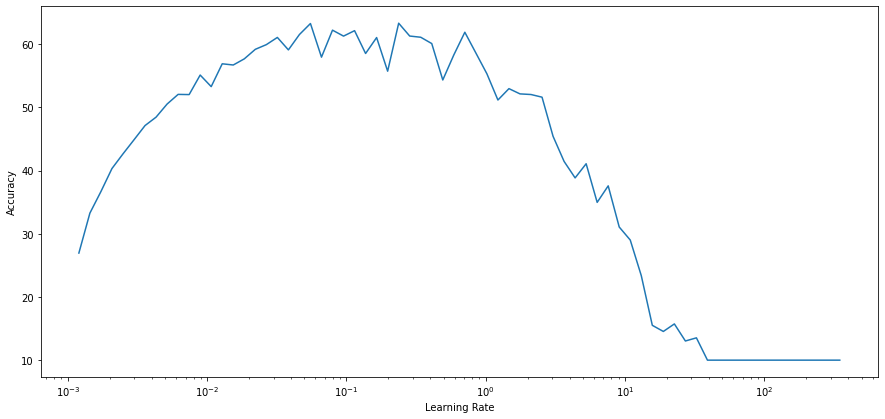

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(2,1,1)
line, =ax.plot(lr_, test_acc)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy")

### Maximum LR = 0.055 (from the above graph)

In [0]:
# max_lr = 0.055
# base_lr = 0.0055

In [15]:
from train_ import train
from test_ import test
from torch.optim.lr_scheduler import CyclicLR, StepLR
criterion = nn.CrossEntropyLoss()

model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.79, weight_decay = 0.0085)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.0055, max_lr = 0.055, step_size_up=5,
                                              step_size_down=19, mode='triangular2')

EPOCHS = 24


test_acc_c = []
train_acc_c = []
trainloss_c = []
testloss_c = []
lr_c= []
epoch_c = []
# loss=1000
# loss = 1000
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH :", epoch)
    trainacc, loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_acc_c.append(trainacc)
    testacc, loss1 = test(model, device, test_loader, criterion)
    test_acc_c.append(testacc)
    trainloss_c.append(loss)
    testloss_c.append(loss1)
    epoch_c.append(epoch)
    scheduler.step()
    # lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr = param_group['lr']
    lr_c.append(lr)
print('Finished Training')


  0%|          | 0/98 [00:00<?, ?it/s]

lr=  0.0055
EPOCH : 0


/content/drive/My Drive/EVA4/assignment11/model11.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Epoch= 0 Loss=2.001192808151245 Batch_id=97 Accuracy=50.00: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 2.0391674 Test Accuracy= 44.4
lr=  0.015400000000000018
EPOCH : 1


Epoch= 1 Loss=1.9895647764205933 Batch_id=97 Accuracy=52.38: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9333296 Test Accuracy= 50.03
lr=  0.025299999999999982
EPOCH : 2


Epoch= 2 Loss=1.9062790870666504 Batch_id=97 Accuracy=59.82: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8784945 Test Accuracy= 53.86
lr=  0.0352
EPOCH : 3


Epoch= 3 Loss=1.9093427658081055 Batch_id=97 Accuracy=61.01: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.9275932 Test Accuracy= 55.7
lr=  0.045100000000000015
EPOCH : 4


Epoch= 4 Loss=1.8393402099609375 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8565644 Test Accuracy= 61.27
lr=  0.05499999999999998
EPOCH : 5


Epoch= 5 Loss=1.8301807641983032 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.8539945 Test Accuracy= 62.43
lr=  0.052394736842105265
EPOCH : 6


Epoch= 6 Loss=1.7601454257965088 Batch_id=97 Accuracy=76.79: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7711293 Test Accuracy= 70.04
lr=  0.04978947368421052
EPOCH : 7


Epoch= 7 Loss=1.7153347730636597 Batch_id=97 Accuracy=82.44: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7138844 Test Accuracy= 73.71
lr=  0.0471842105263158
EPOCH : 8


Epoch= 8 Loss=1.7138421535491943 Batch_id=97 Accuracy=84.82: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7622566 Test Accuracy= 74.08
lr=  0.04457894736842105
EPOCH : 9


Epoch= 9 Loss=1.7078825235366821 Batch_id=97 Accuracy=83.04: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7395552 Test Accuracy= 76.48
lr=  0.041973684210526316
EPOCH : 10


Epoch= 10 Loss=1.6822898387908936 Batch_id=97 Accuracy=85.42: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7752453 Test Accuracy= 70.15
lr=  0.03936842105263159
EPOCH : 11


Epoch= 11 Loss=1.7008323669433594 Batch_id=97 Accuracy=83.63: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7176114 Test Accuracy= 76.96
lr=  0.036763157894736845
EPOCH : 12


Epoch= 12 Loss=1.6825834512710571 Batch_id=97 Accuracy=85.42: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7210379 Test Accuracy= 76.24
lr=  0.034157894736842116
EPOCH : 13


Epoch= 13 Loss=1.6909165382385254 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7100387 Test Accuracy= 75.66
lr=  0.03155263157894736
EPOCH : 14


Epoch= 14 Loss=1.6533434391021729 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.7028068 Test Accuracy= 80.86
lr=  0.02894736842105263
EPOCH : 15


Epoch= 15 Loss=1.656347393989563 Batch_id=97 Accuracy=89.58: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6669396 Test Accuracy= 84.11
lr=  0.026342105263157903
EPOCH : 16


Epoch= 16 Loss=1.6584534645080566 Batch_id=97 Accuracy=89.58: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6460905 Test Accuracy= 84.87
lr=  0.023736842105263146
EPOCH : 17


Epoch= 17 Loss=1.621998906135559 Batch_id=97 Accuracy=92.26: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6600177 Test Accuracy= 84.3
lr=  0.021131578947368425
EPOCH : 18


Epoch= 18 Loss=1.6123383045196533 Batch_id=97 Accuracy=92.26: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6438296 Test Accuracy= 83.36
lr=  0.018526315789473696
EPOCH : 19


Epoch= 19 Loss=1.5987437963485718 Batch_id=97 Accuracy=93.45: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6331568 Test Accuracy= 85.77
lr=  0.01592105263157894
EPOCH : 20


Epoch= 20 Loss=1.5917104482650757 Batch_id=97 Accuracy=93.75: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6357547 Test Accuracy= 85.15
lr=  0.013315789473684211
EPOCH : 21


Epoch= 21 Loss=1.5620959997177124 Batch_id=97 Accuracy=94.05: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6021738 Test Accuracy= 87.83
lr=  0.010710526315789483
EPOCH : 22


Epoch= 22 Loss=1.589720368385315 Batch_id=97 Accuracy=94.94: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test Loss= 1.6130602 Test Accuracy= 88.82
lr=  0.008105263157894727
EPOCH : 23


Epoch= 23 Loss=1.5807703733444214 Batch_id=97 Accuracy=95.54: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]
100%|██████████| 20/20 [00:01<00:00, 10.54it/s]

Test Loss= 1.5950018 Test Accuracy= 90.25
Finished Training


### Learning Rate versus Epoch Graph

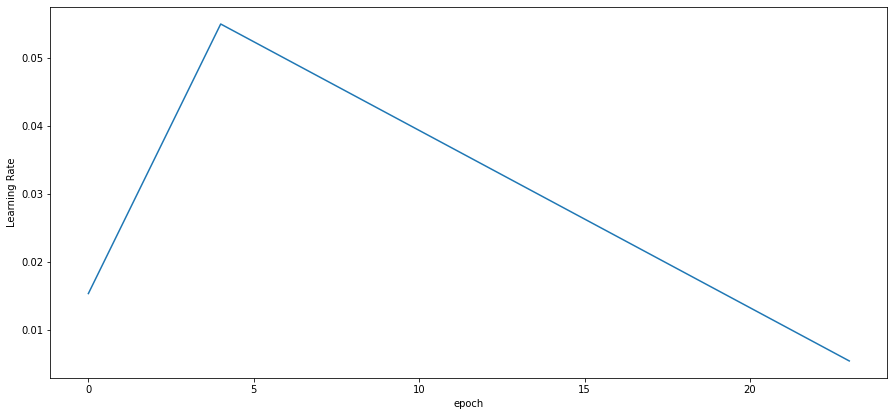

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,1,1)
line, =ax.plot(epoch_c, lr_c)
ax.set_xlabel("epoch")
ax.set_ylabel("Learning Rate")
plt.savefig('LearningRate_Epoch.png')

### Plotting Train and Test Accuracy curves

Text(0, 0.5, 'Accuracy')

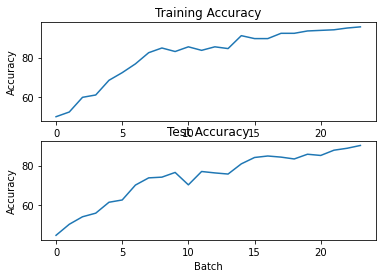

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc_c)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc_c)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")